# Nonlinear Virus Spread

In this demo we consider a model for the spead of a virus (not COVID-19!) in a population. We are interested in estimating the reproduction rate from daily observations of the number of infected individuals. The reproduction rate indicates how many others are (on average) infected by one infected individual per time unit.

In [1]:
using Rocket, GraphPPL, ReactiveMP, Plots, Distributions

## Generate Data

We start by generating a toy dataset for a virus with a reproduction rate $a$. Here, $y$ represents the measured number of infected individuals, and $x$ a latent state.

In [2]:
# Generate toy dataset
T = 30
x_0_data = 0.6
a_data = 1.1

x_data = Vector{Float64}(undef, T)
y_data = Vector{Float64}(undef, T)

x_t_min_data = x_0_data
for t=1:T
    x_data[t] = a_data*x_t_min_data
    y_data[t] = ceil(x_data[t])
    
    x_t_min_data = x_data[t]
end    
;

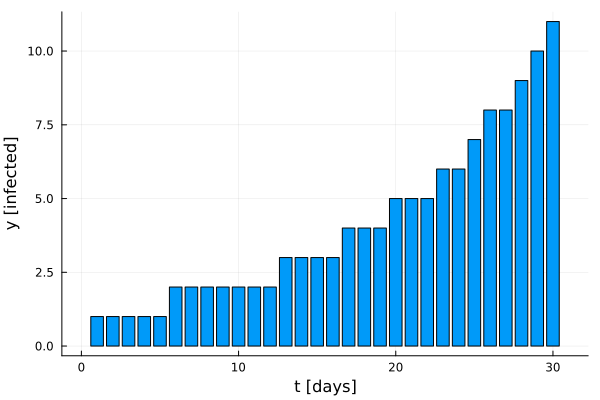

In [3]:
# Inspect data
bar(1:T, y_data, xlabel = "t [days]", ylabel = "y [infected]", label = false)

## Model specification

We define a state-space model, where we specify the state transition by a `g` function. 

In [4]:
g(x_t_min, a) = a * x_t_min

g (generic function with 1 method)

In [9]:
@model function virus_spread(n)
    x = randomvar(n)
    y = datavar(Float64, n)

    a ~ NormalMeanVariance(0.0, 100.0)
    x_0 ~ NormalMeanVariance(1.0, 10.0)

    x_prev = x_0
    for i in 1:n
        # `meta` specifies the approximation method, which will be used 
        # to approximate the nonlinearity
        x[i] ~ g(x_prev, a) where { meta = Linearization() }
        y[i] ~ NormalMeanVariance(x[i], 0.1)
        x_prev = x[i]
    end

end

In [10]:
result = inference(
    model = Model(virus_spread, length(y_data)), 
    data = (y = y_data,),
    options = (limit_stack_depth = 100, ),
    returnvars = KeepLast(), 
    initmessages = (a = NormalMeanVariance(0.0, 10.0), ), 
)

Inference results:
-----------------------------------------
a   = NormalWeightedMeanPrecision{Float64}(xi=1099.8641718498084, w=999.8530549745847)...
x_0 = NormalWeightedMeanPrecision{Float64}(xi=0.1, w=0.1)
x   = NormalWeightedMeanPrecision{Float64}[NormalWeightedMeanPrecision{Float64}(xi=10....


In [11]:
m_x_t, v_x_t = mean.(result.posteriors[:x]), cov.(result.posteriors[:x]);
m_a, v_a = mean.(result.posteriors[:a]), cov.(result.posteriors[:a]);

## Inference results

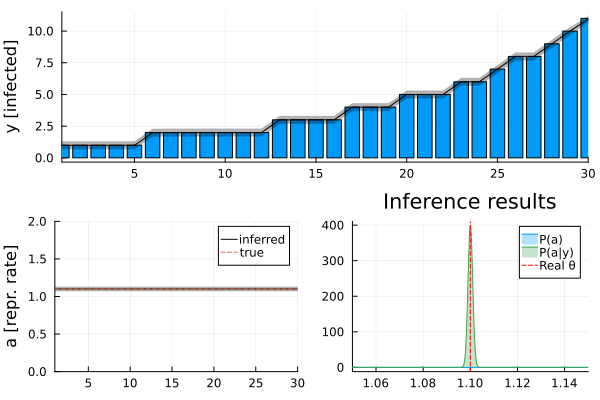

In [12]:
p1 = bar(1:T, y_data, label=false)
p1 = plot!(p1, 1:T, m_x_t, color=:black, ribbon=sqrt.(v_x_t), fillalpha=0.3, xlim=(1,T), ylabel="y [infected]", label=false)
p2 = plot(1:T, m_a*ones(T,), color=:black, ribbon=sqrt.(v_a)*ones(T,), fillalpha=0.3, xlim=(1,T), ylabel="a [repr. rate]", label="inferred")
p2 = plot!(p2, 1:T, a_data*ones(T), linestyle=:dash, label="true ", ylim = (0, 2))

rθ = range(1.05, 1.15, length = 1000)

p3 = plot(title = "Inference results", xlim = (1.05, 1.15))

p3 = plot!(p3, rθ, (x) -> pdf(Normal(0.0, 100.0), x), fillalpha=0.3, fillrange = 0, label="P(a)", c=1,)
p3 = plot!(p3, rθ, (x) -> pdf(Normal(mean(result.posteriors[:a]), var(result.posteriors[:a])), x), fillalpha=0.3, fillrange = 0, label="P(a|y)", c=3)
p3 = vline!(p3, [ a_data ], label="Real θ", linestyle=:dash, color = :red)

plot(p1, p2, p3,  layout = @layout([a; b c]))

As we can see the inference results match hidden states with high precision, as well as for the `a` parameter.